In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [26]:
# importing basic libraries
import numpy as np
import pandas as pd
import os

# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# importing library for reading image
from PIL import Image
import glob
import tensorflow as tf
from collections import defaultdict
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D,Flatten, Dense, Dropout, InputLayer,GlobalAveragePooling2D
#from tensorflow.keras.layers.pooling import MaxPool2D
#from tensorflow.keras.layers.convolutional import Convolution2D,Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization

In [4]:
!rmdir /root/.kaggle
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c recognizing-faces-in-the-wild

  0% 0.00/8.67k [00:00<?, ?B/s]
100% 8.67k/8.67k [00:00<00:00, 16.3MB/s]
  0% 0.00/354k [00:00<?, ?B/s]
100% 354k/354k [00:00<00:00, 48.8MB/s]
 62% 21.0M/34.1M [00:00<00:00, 20.9MB/s]
100% 34.1M/34.1M [00:00<00:00, 63.0MB/s]
 85% 23.0M/27.1M [00:00<00:00, 53.2MB/s]
100% 27.1M/27.1M [00:00<00:00, 107MB/s] 
  0% 0.00/33.7k [00:00<?, ?B/s]
100% 33.7k/33.7k [00:00<00:00, 33.5MB/s]
 92% 120M/130M [00:01<00:00, 121MB/s]
100% 130M/130M [00:01<00:00, 127MB/s]
  0% 0.00/1.47k [00:00<?, ?B/s]
100% 1.47k/1.47k [00:00<00:00, 4.36MB/s]
  0% 0.00/77.6k [00:00<?, ?B/s]
100% 77.6k/77.6k [00:00<00:00, 76.6MB/s]
 87% 26.0M/29.7M [00:00<00:00, 36.5MB/s]
100% 29.7M/29.7M [00:00<00:00, 60.5MB/s]
  0% 0.00/156k [00:00<?, ?B/s]
100% 156k/156k [00:00<00:00, 53.7MB/s]
 77% 53.0M/68.6M [00:00<00:00, 76.6MB/s]
100% 68.6M/68.6M [00:00<00:00, 107MB/s] 
 94% 105M/111M [00:01<00:00, 62.1MB/s] 
100% 111M/111M [00:01<00:00, 78.5MB/s]


In [6]:
import os

In [7]:
!mkdir face

In [8]:
!unzip 'train.zip' -d '/content/face/train'
!unzip 'test.zip' -d '/content/face/test'

Streaming output truncated to the last 5000 lines.
  inflating: /content/face/test/face04688.jpg  
  inflating: /content/face/test/face03972.jpg  
  inflating: /content/face/test/face02593.jpg  
  inflating: /content/face/test/face00836.jpg  
  inflating: /content/face/test/face05284.jpg  
  inflating: /content/face/test/face03261.jpg  
  inflating: /content/face/test/face00582.jpg  
  inflating: /content/face/test/face02696.jpg  
  inflating: /content/face/test/face05325.jpg  
  inflating: /content/face/test/face04973.jpg  
  inflating: /content/face/test/face02902.jpg  
  inflating: /content/face/test/face06245.jpg  
  inflating: /content/face/test/face00645.jpg  
  inflating: /content/face/test/face03284.jpg  
  inflating: /content/face/test/face00188.jpg  
  inflating: /content/face/test/face05490.jpg  
  inflating: /content/face/test/face01683.jpg  
  inflating: /content/face/test/face05566.jpg  
  inflating: /content/face/test/face03288.jpg  
  inflating: /content/face/test/face0

In [9]:
df = pd.read_csv('train_relationships.csv')

In [10]:
df.head()

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


In [11]:
df.describe()

,p1,p2
count,3598,3598
unique,1725,1439
top,F0552/MID1,F0690/MID10
freq,9,8


In [12]:
# finding the number of families in training and putting them in a list
train_url =  '/content/face/train/'
family = os.listdir(train_url)
print('the number of families are {}'.format(len(family)))
print(family[:10])

the number of families are 470
['F0002', 'F0843', 'F0725', 'F0524', 'F0716', 'F0894', 'F0024', 'F0621', 'F0592', 'F0431']


In [13]:
#finding the number of families in the test case and putting them in a list
# finding the number of families in training and putting them in a list
test_url =  '/content/face/test/'
family_pics = os.listdir(test_url)
print("the number of testing pictures are {}".format(len(family_pics)))
print(family_pics[:10])

the number of testing pictures are 6282
['face04052.jpg', 'face04994.jpg', 'face04287.jpg', 'face05798.jpg', 'face00471.jpg', 'face03586.jpg', 'face03864.jpg', 'face06114.jpg', 'face02305.jpg', 'face00656.jpg']


In [14]:
# to list out all the members of a particular family
members = {i:sorted(os.listdir(train_url+i)) for i in family}

In [15]:
print(members)

{'F0002': ['MID1', 'MID2', 'MID3'], 'F0843': ['MID1', 'MID2', 'MID3', 'MID4', 'MID5'], 'F0725': ['MID1', 'MID2', 'MID3'], 'F0524': ['MID1', 'MID3'], 'F0716': ['MID1', 'MID2', 'MID3', 'MID4', 'MID5'], 'F0894': ['MID1', 'MID2', 'MID3'], 'F0024': ['MID1', 'MID2', 'MID3', 'MID4', 'MID5'], 'F0621': ['MID1', 'MID2', 'MID3', 'MID4', 'MID5'], 'F0592': ['MID1', 'MID2', 'MID3', 'MID4'], 'F0431': ['MID2', 'MID4'], 'F0238': ['MID1', 'MID3', 'MID4', 'MID5', 'MID6'], 'F0284': ['MID1', 'MID2', 'MID3', 'MID4', 'MID5', 'MID6'], 'F0179': ['MID1', 'MID2', 'MID3', 'MID4'], 'F0748': ['MID1', 'MID3'], 'F0233': ['MID1', 'MID2', 'MID3', 'MID5', 'MID6'], 'F0785': ['MID1', 'MID10', 'MID2', 'MID3', 'MID4', 'MID5', 'MID6', 'MID7', 'MID8', 'MID9'], 'F0565': ['MID1', 'MID2', 'MID3', 'MID4'], 'F0390': ['MID1', 'MID10', 'MID11', 'MID2', 'MID3', 'MID4', 'MID5', 'MID6', 'MID7', 'MID8', 'MID9'], 'F0918': ['MID1', 'MID2', 'MID3', 'MID4', 'MID5', 'MID6', 'MID7', 'MID8'], 'F0411': ['MID1', 'MID2', 'MID3'], 'F0443': ['MID1'

In [16]:
import pathlib

In [22]:
data_dir = pathlib.Path(train_url)
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(image_count)

12379


In [24]:
batch_size = 32
img_height = 180
img_width = 180

In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
)

Found 12379 files belonging to 470 classes.


In [38]:
class_names = train_ds.class_names
print(class_names)

['F0002', 'F0005', 'F0009', 'F0010', 'F0016', 'F0017', 'F0020', 'F0022', 'F0023', 'F0024', 'F0030', 'F0031', 'F0036', 'F0038', 'F0039', 'F0040', 'F0041', 'F0044', 'F0049', 'F0050', 'F0051', 'F0052', 'F0054', 'F0058', 'F0059', 'F0063', 'F0064', 'F0068', 'F0070', 'F0074', 'F0077', 'F0081', 'F0086', 'F0091', 'F0093', 'F0097', 'F0099', 'F0101', 'F0105', 'F0106', 'F0109', 'F0110', 'F0112', 'F0113', 'F0118', 'F0119', 'F0122', 'F0123', 'F0124', 'F0126', 'F0128', 'F0129', 'F0130', 'F0132', 'F0134', 'F0135', 'F0137', 'F0138', 'F0142', 'F0146', 'F0150', 'F0151', 'F0154', 'F0155', 'F0157', 'F0158', 'F0159', 'F0160', 'F0161', 'F0162', 'F0164', 'F0165', 'F0167', 'F0168', 'F0169', 'F0170', 'F0174', 'F0178', 'F0179', 'F0183', 'F0188', 'F0191', 'F0192', 'F0194', 'F0195', 'F0196', 'F0197', 'F0198', 'F0199', 'F0202', 'F0203', 'F0206', 'F0209', 'F0210', 'F0211', 'F0212', 'F0214', 'F0215', 'F0216', 'F0225', 'F0227', 'F0228', 'F0231', 'F0233', 'F0236', 'F0237', 'F0238', 'F0241', 'F0242', 'F0244', 'F0245', 

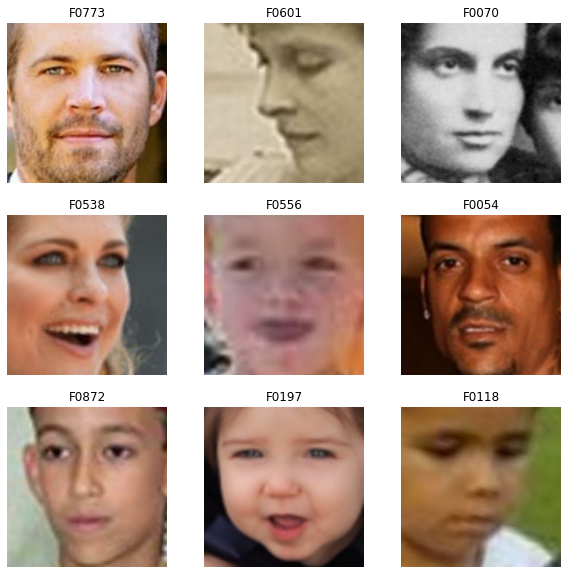

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
dir(train_ds)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_batch_size',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_deserialize_from_proto',
 '_drop_remainder',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serializ

In [41]:
 # building a model
 from keras import backend as K

In [42]:
K.set_image_data_format('channels_first')

In [43]:
import keras
from keras.models import Model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Activation

In [44]:
!pip install keras-vggface

In [50]:
# to remove some utils files that do not exit 
!pip show keras-vggface
!pip install keras_applications
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: six, pillow, h5py, keras, scipy, pyyaml, numpy
Required-by: 


In [51]:
import keras_vggface

In [52]:
from keras_vggface.vggface import VGGFace

In [53]:
dir(keras_vggface.vggface)

['RESNET50',
 'SENET50',
 'VGG16',
 'VGGFace',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'print_function']

In [54]:
vgg_facenet = VGGFace(model ='resnet50', include_top = False)
output = vgg_facenet.layers[-2].output
#output = keras.layers.Flatten()(output)
vgg_facenet = Model(vgg_facenet.input, outputs=output)
for layer in vgg_facenet.layers:
    layer.trainable = False
vgg_facenet.summary()

94707712/94694792 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, None, No  0           []                               
                                ne)]                                                              
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 64, None, No  9408        ['input_1[0][0]']                
                                ne)                                                               
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 64, None, No  256        ['conv1/7x7_s2[0][0]']           
 ation)                      

/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py:298: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [48]:
def baseline_model():
  model = Sequential()
  model.add(vgg_facenet)
  model.add(Dense(256,activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))
  return model

In [55]:
baseline = baseline_model()

ValueError: ignored

In [ ]:
model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 224, 224) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 64, 112, 112) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 64, 112, 112) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 112, 112) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________